# Deep Learning Model Testing Methods

This topic focuses on __developing testing methods__ in deep learning models during training and inference time. The subject involves applying probabilistic and information theoric methods on both datasets and models to quantify the unknown situations.

---

## Background
Intermediate level:
- Python
- NumPy, SciPy libraries
- Public-key cryptography, or asymmetric cryptography
- Deep learning
   - Keras
   - Tensorflow
   - Scikit-learn

---
## 1. Uncertainty in DL models
- A deep learning model should be able to say: 
   - *“sorry, I don’t know”*.
   - *“I am not sure for the given input”*
- The reliability/quality of the prediction

### 1.1 Uncertainty Types
---
- __Epistemic Uncertainty__ (Model related):
   - Uncertainty in models (not in data)
   - “Epistemic”: Greek “episteme” = knowledge
   - Reducible: more data helps
   - There are two types Epistemic uncertainty
      - __Model Uncertainty__ : Neural network model’s neuron weights are not optimized well for the domain
      - __Approximation uncertainty__: Model structure (# of layers, activation functions (ReLU, Tanh, Sigmoid etc), optimizer functions (SGD, RMSProp, Adam, Adamax etc)
---
- __Aleatoric Uncertainty__ (Data related):
   - Uncertainty: because of the noise input dataset.
   - “Aleatoric”: Latin “aleator” = dice players
   - Noise in the training data
   - Stochastic, irreducible in data (noise)
      - More data doesn’t help
   - For instance; noise sensor readings for a CPS application!
   


---
---


## 2. Uncertainty Quantification in DL model predictions



### 2.1 MC Dropouts
![MC Dropouts](https://docs.aws.amazon.com/prescriptive-guidance/latest/ml-quantifying-uncertainty/images/mc-dropout.png)

## 3. Aims
- Understanding of uncertainty in DL models
- Quantifying the uncertainties in CPS datasets (Robotics, Autonomous Driving etc.)
- Re-training the DL models with highly uncertain inputs to improve the robustness of the models
- !!! **Generation** of the highly uncertain inputs to test DL models like software engineering testing approach

## 4. A Simple Demonstration

In [2]:
!pip install -q uncertainty-wizard

     |████████████████████████████████| 48 kB 3.0 MB/s 


In [3]:
import tensorflow as tf
import keras
import numpy as np
from keras.utils import np_utils

import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd

import matplotlib.pyplot as plt

In [4]:
num_classes = 10
input_shape = (28, 28, 1)

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

11501568/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [5]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

In [6]:
batch_size = 5000
epochs = 10

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/10
11/11 [==============================] - 18s 176ms/step - loss: 2.1422 - accuracy: 0.3340 - val_loss: 1.7970 - val_accuracy: 0.7687
Epoch 2/10
11/11 [==============================] - 1s 85ms/step - loss: 1.4475 - accuracy: 0.6562 - val_loss: 0.8010 - val_accuracy: 0.8445
Epoch 3/10
11/11 [==============================] - 1s 87ms/step - loss: 0.7580 - accuracy: 0.7666 - val_loss: 0.3761 - val_accuracy: 0.8970
Epoch 4/10
11/11 [==============================] - 1s 86ms/step - loss: 0.5005 - accuracy: 0.8403 - val_loss: 0.2614 - val_accuracy: 0.9275
Epoch 5/10
11/11 [==============================] - 1s 85ms/step - loss: 0.3731 - accuracy: 0.8879 - val_loss: 0.2085 - val_accuracy: 0.9420
Epoch 6/10
11/11 [==============================] - 1s 88ms/step - loss: 0.3001 - accuracy: 0.9098 - val_loss: 0.1739 - val_accuracy: 0.9543
Epoch 7/10
11/11 [==============================] - 1s 89ms/step - loss: 0.2525 - accuracy: 0.9247 - val_loss: 0.1486 - val_accuracy: 0.9605
Epoch 8/10


## Testing

- How many samples were mis-classified?
- Was there any error in the data (labeling error?)

In [7]:
pred = model.predict(x_test)
y_pred = np.argmax(pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# count how many correct predictions
acc = sum(y_true == y_pred)/len(y_true)*100
print('Accuracy = %.3f' % (acc))

Accuracy = 96.620


In [8]:
# Total number of mis-classifications
print("%d samples mis-classified out of %d" % (sum(y_true != y_pred), len(y_true)))

# find the samples which are mis-classified
x_mis = x_test[y_pred != y_true]
y_mis_true = y_true[y_pred != y_true]
y_mis_pred = y_pred[y_pred != y_true]

338 samples mis-classified out of 10000


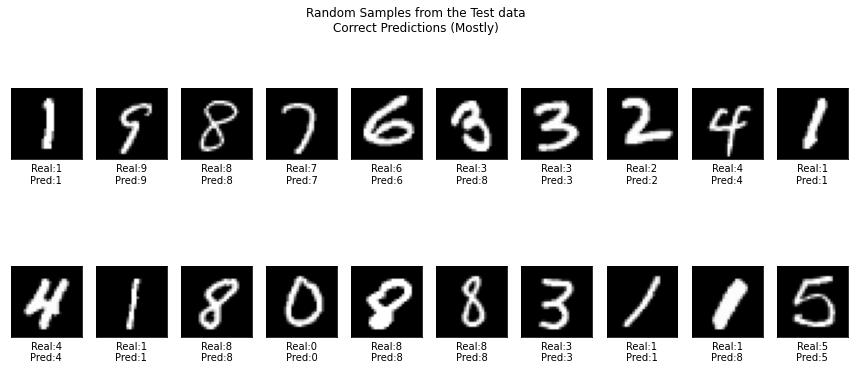

In [9]:
# visualize some of the predictions randomly
NUM_OF_SAMPLES = 20
fig, ax = plt.subplots(nrows=2, ncols=10, figsize=(15,6))

for i in range(NUM_OF_SAMPLES):
    index = np.random.choice(len(x_test))
    image = x_test[index] # plot the sample
    ax[i//10][i%10].imshow(image.reshape([28,28]), cmap='gray')
    ax[i//10][i%10].set_xticks([])
    ax[i//10][i%10].set_yticks([])
    ax[i//10][i%10].set_xlabel('Real:'+ str(y_true[index]) + '\nPred:' + str(y_pred[index]))

fig.suptitle('Random Samples from the Test data\nCorrect Predictions (Mostly)')
plt.show()

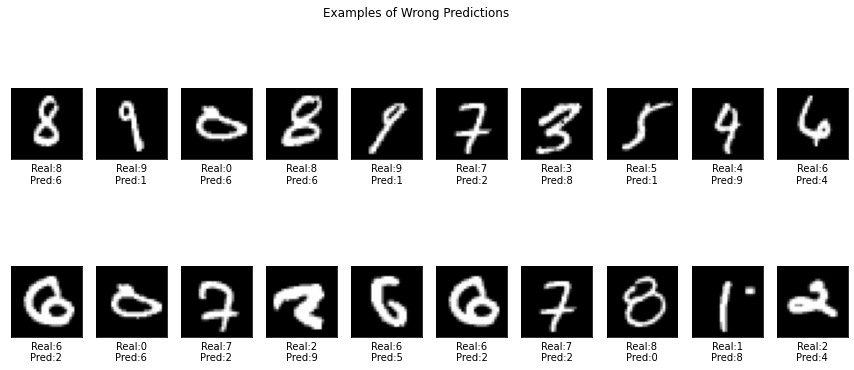

In [10]:
# visualize some of the mis-classifications
NUM_OF_SAMPLES = 20
fig, ax = plt.subplots(nrows=2, ncols=10, figsize=(15,6))

for i in range(NUM_OF_SAMPLES):
    index = np.random.choice(len(x_mis))
    image = x_mis[index] # plot the sample
    ax[i//10][i%10].imshow(image.reshape([28,28]), cmap='gray')
    ax[i//10][i%10].set_xticks([])
    ax[i//10][i%10].set_yticks([])
    ax[i//10][i%10].set_xlabel('Real:'+ str(y_mis_true[index]) + '\nPred:' + str(y_mis_pred[index]))

fig.suptitle('Examples of Wrong Predictions')
plt.show()

## Exploration of Uncertainty Wizard

Three kinds of uncertainty calculation.

1. Point Predictor Models (single models)
2. Stochastic Models (e.g. MC-Dropout)
3. Ensemble Models (Multiple models)

In [11]:
import uncertainty_wizard as uwiz
stochastic_model = uwiz.models.stochastic_from_keras(model)

### 1. Point Predictor Models
Base their prediction and uncertainty quantification based on a single inference on a single neural network. Typically use the softmax output probabilities to caclulate different measures such as entropy, var_ratio etc.

In [12]:
pred, unc = stochastic_model.predict_quantified(x_test, quantifier='pcs')



- pred is the same as y_pred (prediction by the single model)
- unc is the uncertainty using prediction confidence score (higher score mean lower uncertainty)

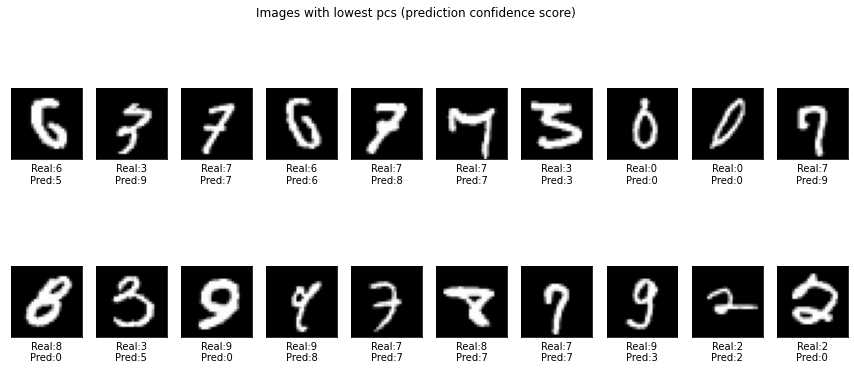

In [13]:
# show images with the lowest pcs (prediction confidence scores)
pos = np.argsort(unc)

# visualize some of the images with low prediction confidence
NUM_OF_SAMPLES = 20
fig, ax = plt.subplots(nrows=2, ncols=10, figsize=(15,6))

for i in range(NUM_OF_SAMPLES):
    index = pos[i]
    image = x_test[index] # plot the sample
    ax[i//10][i%10].imshow(image.reshape([28,28]), cmap='gray')
    ax[i//10][i%10].set_xticks([])
    ax[i//10][i%10].set_yticks([])
    ax[i//10][i%10].set_xlabel('Real:'+ str(y_true[index]) + '\nPred:' + str(y_pred[index]))

fig.suptitle('Images with lowest pcs (prediction confidence score)')
plt.show()

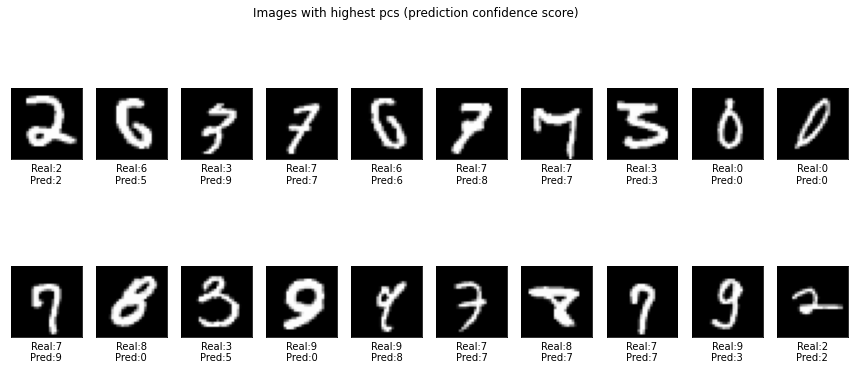

In [14]:
# show images with the highest pcs (prediction confidence scores)
pos = np.argsort(-unc)

# visualize some of the images with low prediction confidence
NUM_OF_SAMPLES = 20
fig, ax = plt.subplots(nrows=2, ncols=10, figsize=(15,6))

for i in range(NUM_OF_SAMPLES):
    index = pos[-i]
    image = x_test[index] # plot the sample
    ax[i//10][i%10].imshow(image.reshape([28,28]), cmap='gray')
    ax[i//10][i%10].set_xticks([])
    ax[i//10][i%10].set_yticks([])
    ax[i//10][i%10].set_xlabel('Real:'+ str(y_true[index]) + '\nPred:' + str(y_pred[index]))

fig.suptitle('Images with highest pcs (prediction confidence score)')
plt.show()

## 2. Stochastic Models
MC-Dropout (dropout druing inference time) which gives multiple models (ensembles) in essence without training multiple models.

In [15]:
# , 'var_ratio'
# ,'StandardDeviation'
results = stochastic_model.predict_quantified(x_test, quantifier=['predictive_entropy', 'var_ratio','StandardDeviation'],
                                             sample_size=32)

In [16]:
import math as m

In [17]:
df = pd.DataFrame({'id_no':np.arange(start=0, stop=x_test.shape[0], step=1, dtype=int),'y_hat':results[0][0],
                  'entropy_uncertainty':results[0][1], 'y_true':y_true, 'var_ratio':results[1][1]})

In [18]:
df

,id_no,y_hat,entropy_uncertainty,y_true,var_ratio
0,0,7,0.001279,7,0.00000
1,1,2,0.205900,2,0.00000
2,2,1,0.088957,1,0.00000
3,3,0,0.019948,0,0.00000
4,4,4,0.075535,4,0.00000
...,...,...,...,...,...
9995,9995,2,0.004208,2,0.00000
9996,9996,3,0.016648,3,0.00000
9997,9997,4,0.048914,4,0.00000
9998,9998,5,0.879142,5,0.09375


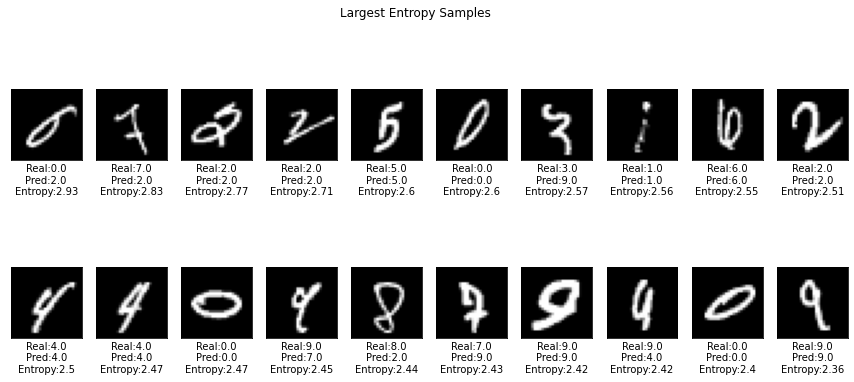

In [19]:
NUM_OF_SAMPLES = 20
df.sort_values(by=['entropy_uncertainty'], ascending=False, inplace=True)
fig, ax = plt.subplots(nrows=2, ncols=10, figsize=(15,6))

i = 0
for index, row in df.head(NUM_OF_SAMPLES).iterrows():
    image = x_test[int(row['id_no']),:] # plot the sample
    
    ax[i//10][i%10].imshow(image.reshape([28,28]), cmap='gray')
    ax[i//10][i%10].set_xticks([])
    ax[i//10][i%10].set_yticks([])
    ax[i//10][i%10].set_xlabel('Real:'+ str(row['y_true']) + '\nPred:' + str(row['y_hat']) + '\nEntropy:' + str(row['entropy_uncertainty'].round(2)))
    i = i+1

fig.suptitle('Largest Entropy Samples')
plt.show()

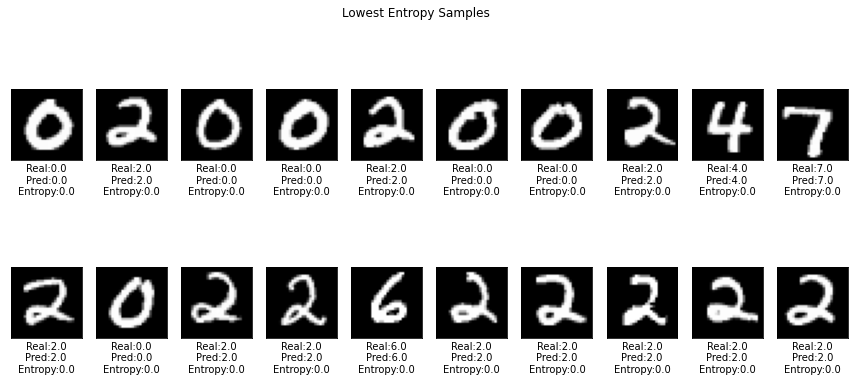

In [20]:
NUM_OF_SAMPLES = 20
# df.sort_values(by=['entropy_uncertainty'], ascending=True, inplace=True)
fig, ax = plt.subplots(nrows=2, ncols=10, figsize=(15,6))

i = 0
for index, row in df.tail(NUM_OF_SAMPLES).iterrows():
    image = x_test[int(row['id_no']),:]# plot the sample
    
    ax[i//10][i%10].imshow(image.reshape([28,28]), cmap='gray')
    ax[i//10][i%10].set_xticks([])
    ax[i//10][i%10].set_yticks([])
    ax[i//10][i%10].set_xlabel('Real:'+ str(row['y_true']) + '\nPred:' + str(row['y_hat']) + '\nEntropy:' + str(row['entropy_uncertainty'].round(2)))
    i = i+1
fig.suptitle('Lowest Entropy Samples')
plt.show()

- Largest Entropy samples are mostly mis-classifications 

- Lowest Entropy samples are mostly correct predictions, because the model is quite certain about its prediction!

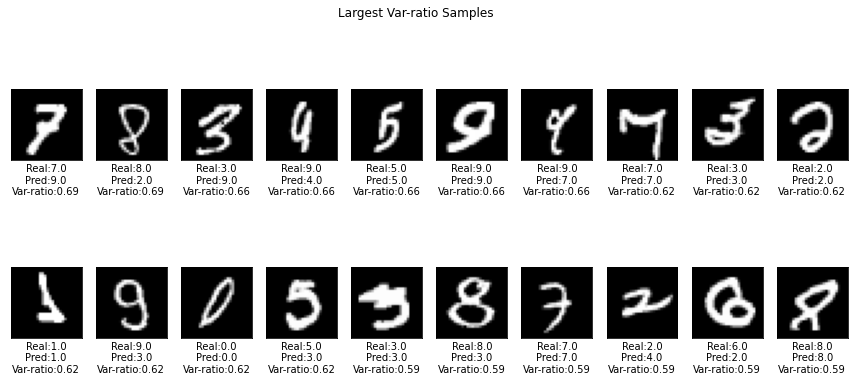

In [21]:
NUM_OF_SAMPLES = 20
df.sort_values(by=['var_ratio'], ascending=False, inplace=True)
fig, ax = plt.subplots(nrows=2, ncols=10, figsize=(15,6))

i = 0
for index, row in df.head(NUM_OF_SAMPLES).iterrows():
    image = x_test[int(row['id_no']),:] # plot the sample
    
    ax[i//10][i%10].imshow(image.reshape([28,28]), cmap='gray')
    ax[i//10][i%10].set_xticks([])
    ax[i//10][i%10].set_yticks([])
    ax[i//10][i%10].set_xlabel('Real:'+ str(row['y_true']) + '\nPred:' + str(row['y_hat']) + '\nVar-ratio:' + str(row['var_ratio'].round(2)))
    i = i+1

fig.suptitle('Largest Var-ratio Samples')
plt.show()

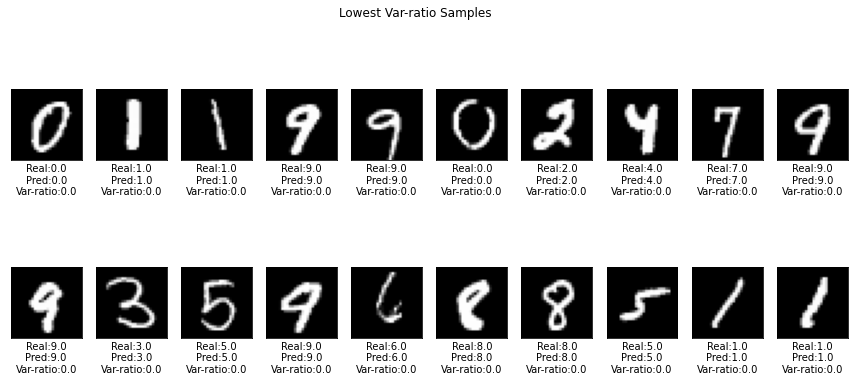

In [22]:
NUM_OF_SAMPLES = 20
df.sort_values(by=['var_ratio'], ascending=True, inplace=True)
fig, ax = plt.subplots(nrows=2, ncols=10, figsize=(15,6))

i = 0
for index, row in df.head(NUM_OF_SAMPLES).iterrows():
    image = x_test[int(row['id_no']),:] # plot the sample
    
    ax[i//10][i%10].imshow(image.reshape([28,28]), cmap='gray')
    ax[i//10][i%10].set_xticks([])
    ax[i//10][i%10].set_yticks([])
    ax[i//10][i%10].set_xlabel('Real:'+ str(row['y_true']) + '\nPred:' + str(row['y_hat']) + '\nVar-ratio:' + str(row['var_ratio'].round(2)))
    i = i+1

fig.suptitle('Lowest Var-ratio Samples')
plt.show()

In [23]:
df = pd.DataFrame({'id_no':np.arange(start=0, stop=x_test.shape[0], step=1, dtype=int),'y_hat':results[0][0],
                  'entropy_uncertainty':results[0][1], 'y_true':y_true,'StandardDeviation':results[1][1]})
df

,id_no,y_hat,entropy_uncertainty,y_true,StandardDeviation
0,0,7,0.001279,7,0.00000
1,1,2,0.205900,2,0.00000
2,2,1,0.088957,1,0.00000
3,3,0,0.019948,0,0.00000
4,4,4,0.075535,4,0.00000
...,...,...,...,...,...
9995,9995,2,0.004208,2,0.00000
9996,9996,3,0.016648,3,0.00000
9997,9997,4,0.048914,4,0.00000
9998,9998,5,0.879142,5,0.09375


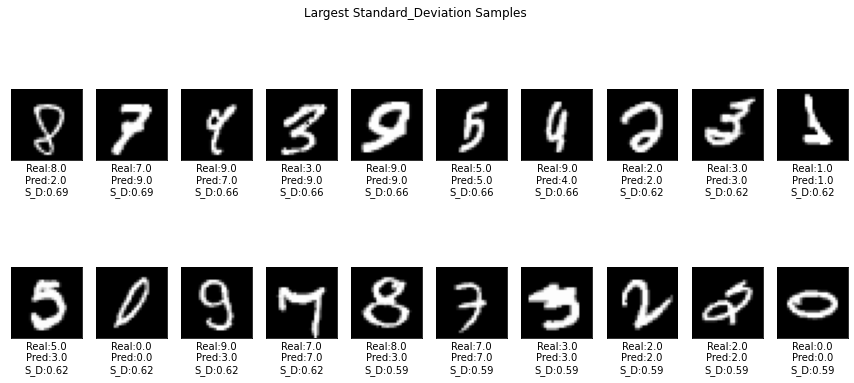

In [24]:
NUM_OF_SAMPLES = 20
df.sort_values(by=['StandardDeviation'], ascending=False, inplace=True)
fig, ax = plt.subplots(nrows=2, ncols=10, figsize=(15,6))

i = 0
for index, row in df.head(NUM_OF_SAMPLES).iterrows():
    image = x_test[int(row['id_no']),:] # plot the sample
    
    ax[i//10][i%10].imshow(image.reshape([28,28]), cmap='gray')
    ax[i//10][i%10].set_xticks([])
    ax[i//10][i%10].set_yticks([])
    ax[i//10][i%10].set_xlabel('Real:'+ str(row['y_true']) + '\nPred:' + str(row['y_hat']) + '\nS_D:' + str(row['StandardDeviation'].round(2)))
    i = i+1

fig.suptitle('Largest Standard_Deviation Samples')
plt.show()

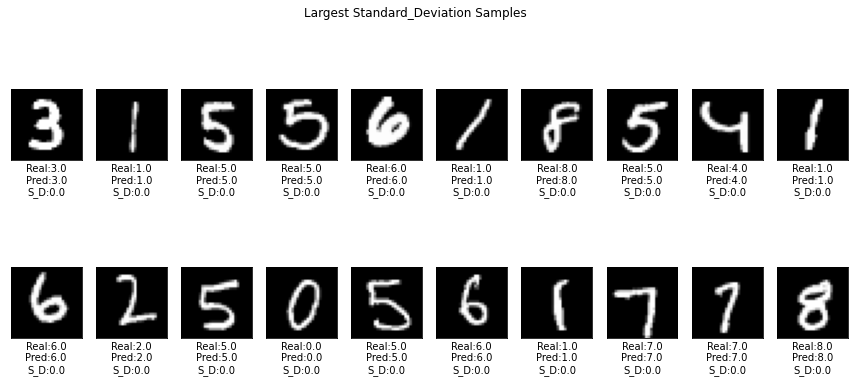

In [25]:
NUM_OF_SAMPLES = 20
df.sort_values(by=['StandardDeviation'], ascending=True, inplace=True)
fig, ax = plt.subplots(nrows=2, ncols=10, figsize=(15,6))

i = 0
for index, row in df.head(NUM_OF_SAMPLES).iterrows():
    image = x_test[int(row['id_no']),:] # plot the sample
    
    ax[i//10][i%10].imshow(image.reshape([28,28]), cmap='gray')
    ax[i//10][i%10].set_xticks([])
    ax[i//10][i%10].set_yticks([])
    ax[i//10][i%10].set_xlabel('Real:'+ str(row['y_true']) + '\nPred:' + str(row['y_hat']) + '\nS_D:' + str(row['StandardDeviation'].round(2)))
    i = i+1

fig.suptitle('Largest Standard_Deviation Samples')
plt.show()

In [26]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

In [29]:
mean_y_hat = df['y_hat'].mean()
std_y_hat = df['y_hat'].std()
mean_y_true = df['y_true'].mean()
std_y_true = df['y_true'].std()

In [30]:
print(mean_y_hat,"/",std_y_hat,"/",mean_y_true,"/",std_y_true)

4.4056 / 2.8974002369043323 / 4.4434 / 2.8958651632119112


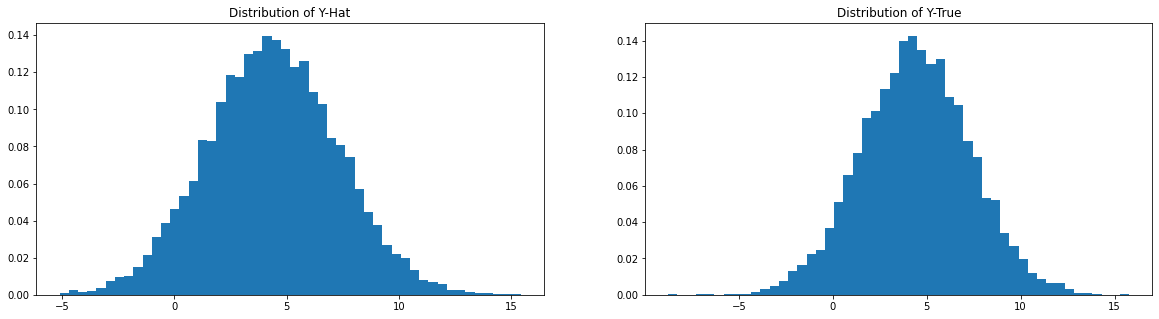

In [34]:
𝜇_q = mean_y_hat
𝜎_q = std_y_hat
𝜇_p = mean_y_true
𝜎_p = std_y_true

distribution_q = tfd.Normal(loc=𝜇_q, scale=𝜎_q)
distribution_p = tfd.Normal(loc=𝜇_p, scale=𝜎_p)


n_samples = 10000
samples_q = distribution_q.sample(n_samples)
samples_p = distribution_p.sample(n_samples)

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.hist(samples_q, bins=50, density=True)
plt.gca().set_title('Distribution of Y-Hat')
plt.subplot(1, 2, 2)
plt.hist(samples_p, bins=50, density=True)
plt.gca().set_title('Distribution of Y-True')
plt.show()

In [35]:
tfd.kl_divergence(distribution_q, distribution_p)

<tf.Tensor: shape=(), dtype=float64, numpy=8.547257807890079e-05>

In [36]:
tfd.kl_divergence(distribution_p, distribution_q)

<tf.Tensor: shape=(), dtype=float64, numpy=8.538213266682057e-05>

# New Section

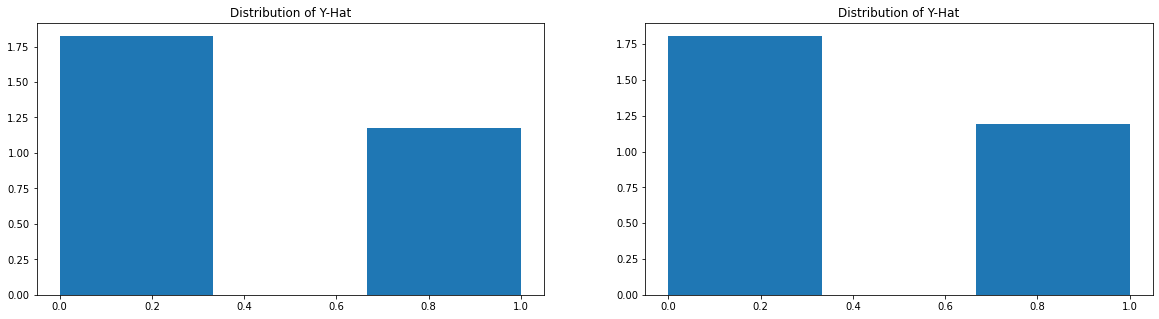

In [42]:
# (mean_y_hat,"/",std_y_hat,"/",mean_y_true,"/",std_y_true)
distribution_q = tfd.Categorical(probs=[mean_y_hat, std_y_hat])

distribution_p = tfd.Categorical(probs=[mean_y_true, std_y_true])

samples_q = distribution_q.sample(n_samples)
samples_p = distribution_p.sample(n_samples)

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.hist(samples_q, bins=3, density=True)
plt.gca().set_title('Distribution of Y-Hat')
plt.subplot(1, 2, 2)
plt.hist(samples_p, bins=3, density=True)
plt.gca().set_title('Distribution of Y-True')
plt.show()